MVPでBucketIteratorにして、embもモデルから切り離した

CosineAnnealingしてる

lstm, cosine annealing

なんか後ろのほうは性能落ちてるっぽいけど、アンサンブルすれば性能向上する。 slight overfitでアンサンブルが向上するやつね

In [1]:
import numpy as np
import pandas as pd
import os
import time
import gc
import random
from contextlib import contextmanager
from fastprogress import master_bar, progress_bar
from keras.preprocessing import text, sequence
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [53]:
NUM_MODELS = 2
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 2 * LSTM_UNITS
MAX_LEN = 220
batch_size = 512
n_seeds = 2
n_splits = 3
n_epochs = 3
EMBED_SIZE = 300


In [54]:
MODEL_PATH = '../models/mvp-noaux-debug'
if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

In [4]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

In [6]:
%%time
import joblib
with open('../input/crawl_emb_processed.joblib', 'rb') as f:
    crawl_emb_dict = joblib.load(f)
    

CPU times: user 1min 26s, sys: 2.88 s, total: 1min 28s
Wall time: 1min 30s


In [7]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [8]:
%%time

import re
# これだと、'はembeddingに結構入ってるのに除外されちゃう。　よくないので ' だけ抜いた
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x: str) -> str:
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, ' {} '.format(punct))
    return x

# 9.9G
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

x_train = train['comment_text'].apply(lambda x: clean_text(x))
y_train = np.where(train['target'] >= 0.5, 1, 0)
x_test = test['comment_text'].apply(lambda x: clean_text(x))
del test
gc.collect()

CPU times: user 23.1 s, sys: 914 ms, total: 24 s
Wall time: 24.8 s


In [9]:
%%time
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(x_train) + list(x_test))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

CPU times: user 2min 17s, sys: 221 ms, total: 2min 17s
Wall time: 2min 17s


In [10]:
max_features = len(tokenizer.word_index) + 1
max_features

378798

In [11]:
def build_matrix(word_index, embedding_dict):
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_dict[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

emb_mat_crawl, oov = build_matrix(tokenizer.word_index, crawl_emb_dict)

In [12]:
del crawl_emb_dict
gc.collect()

0

In [13]:
5 // 2 + 1

3

In [14]:
random.random()

0.9664535356921388

In [15]:
import math
class BucketIterator(object):
    def __init__(self, data, label, batch_size, pad_token,
                length_quantile=0.95):
        self.data = data
        self.label = label
        self.index_sorted = sorted(np.random.permutation(len(self.data)), key=lambda i: len(self.data[i]))
        self.batch_size = batch_size
        self.i_batch = 0
        self.pad_token = pad_token
        self.length_quantile = length_quantile
    
    def __len__(self):
        return len(self.data) // self.batch_size + 1
    
    def __iter__(self):
        return self
    
    def __next__(self):
        index_batch = self.index_sorted[self.i_batch * self.batch_size: (self.i_batch + 1) * self.batch_size]
        
        if not index_batch:
            self.i_batch = 0
            self.index_sorted = sorted(np.random.permutation(len(self.data)), key=lambda i: len(self.data[i]))
            raise StopIteration
                                   
        raw_batch_data = [self.data[i] for i in index_batch]
        batch_label = self.label[index_batch]
            
        max_len = int(math.ceil(np.quantile([len(x) for x in raw_batch_data], self.length_quantile)))
        padded_batch = []
        for sample in raw_batch_data:
            sample = sample + [self.pad_token for _ in range(max_len - len(sample))]
            padded_batch.append(sample[:max_len])
            
        self.i_batch += 1
            
        return padded_batch, batch_label, index_batch

In [20]:
emb_mat_torch = torch.tensor(emb_mat_crawl, dtype=torch.float32).cuda()

In [41]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x
    
class LSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMLayer, self).__init__()
        
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            bias=False,
                            bidirectional=True,
                            batch_first=True)
        
        self.init_weights()
        
    def init_weights(self):
        ih = (param.data for name, param in self.named_parameters() if 'weight_ih' in name)
        hh = (param.data for name, param in self.named_parameters() if 'weight_hh' in name)
        b = (param.data for name, param in self.named_parameters() if 'bias' in name)
        for k in ih:
            nn.init.xavier_uniform_(k)
        for k in hh:
            nn.init.orthogonal_(k)
        for k in b:
            nn.init.constant_(k, 0)

    def forward(self, x):
        lstm_outputs, (lstm_states, _) = self.lstm(x)
        return lstm_outputs, lstm_states
    
class GRULayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRULayer, self).__init__()
        
        self.gru = nn.GRU(input_size=input_size,
                          hidden_size=hidden_size,
                          bias=False,
                          bidirectional=True,
                          batch_first=True)
        
        self.init_weights()
        
    def init_weights(self):
        ih = (param.data for name, param in self.named_parameters() if 'weight_ih' in name)
        hh = (param.data for name, param in self.named_parameters() if 'weight_hh' in name)
        b = (param.data for name, param in self.named_parameters() if 'bias' in name)
        for k in ih:
            nn.init.xavier_uniform_(k)
        for k in hh:
            nn.init.orthogonal_(k)
        for k in b:
            nn.init.constant_(k, 0)

    def forward(self, x):
        gru_outputs, gru_state = self.gru(x)
        return gru_outputs, gru_state
    
class NeuralNet(nn.Module):
    def __init__(self, embed_size):
        super(NeuralNet, self).__init__()
        self.embedding_dropout = SpatialDropout(0.3)
        
        self.lstm1 = LSTMLayer(embed_size, LSTM_UNITS)
        self.linear1 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        
        self.linear_out = nn.Linear(DENSE_HIDDEN_UNITS, 1)
        
    def forward(self, x):
        h_embedding = self.embedding_dropout(x)
        
        h_lstm1, _ = self.lstm1(h_embedding)
        
        # global max pooling
        max_pool, _ = torch.max(h_lstm1, 1)
        
        h_conc_linear1  = F.relu(self.linear1(max_pool))
        
        hidden = max_pool + h_conc_linear1
        
        result = self.linear_out(hidden)

        return result

In [22]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

OOF_TRAIN_COL = 'oof_train'
SUBGROUP_AUC_COL = 'subgroup_auc'
BPSN_AUC_COL = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC_COL = 'bnsp_auc'  # stands for background negative, subgroup positive
from sklearn import metrics
def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup_col, label_col, oof_col):
    subgroup_examples = df[df[subgroup_col]]
    return compute_auc(subgroup_examples[label_col], subgroup_examples[oof_col])

def compute_bpsn_auc(df, subgroup_col, label_col, oof_col):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup_col] & ~df[label_col]]
    non_subgroup_positive_examples = df[~df[subgroup_col] & df[label_col]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label_col], examples[oof_col])

def compute_bnsp_auc(df, subgroup_col, label_col, oof_col):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup_col] & df[label_col]]
    non_subgroup_negative_examples = df[~df[subgroup_col] & ~df[label_col]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label_col], examples[oof_col])

def compute_bias_metrics_for_model(df,
                                   subgroup_list,
                                   oof_col,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    record_list = []
    for subgroup in subgroup_list:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(df[df[subgroup]])
        }
        record[SUBGROUP_AUC_COL] = compute_subgroup_auc(df, subgroup, label_col, oof_col)
        record[BPSN_AUC_COL] = compute_bpsn_auc(df, subgroup, label_col, oof_col)
        record[BNSP_AUC_COL] = compute_bnsp_auc(df, subgroup, label_col, oof_col)
        record_list.append(record)
    return pd.DataFrame(record_list).sort_values('subgroup_auc', ascending=True)

TOXICITY_COLUMN = 'target'
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
# Convert taget and identity columns to booleans
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['target'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df

def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC_COL], POWER),
        power_mean(bias_df[BPSN_AUC_COL], POWER),
        power_mean(bias_df[BNSP_AUC_COL], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

def get_various_auc(valid_df, y_pred):
    valid_df = convert_dataframe_to_bool(valid_df.fillna(0))
    valid_df.loc[:, OOF_TRAIN_COL] = y_pred
    valid_df = convert_dataframe_to_bool(valid_df.fillna(0))
    bias_metrics_df = compute_bias_metrics_for_model(valid_df, identity_columns, OOF_TRAIN_COL, TOXICITY_COLUMN)
    overall_auc = calculate_overall_auc(valid_df, OOF_TRAIN_COL)
    return get_final_metric(bias_metrics_df, overall_auc), overall_auc, bias_metrics_df

In [43]:
y_train_torch = torch.tensor(y_train, dtype=torch.float32).cuda()

In [24]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

505151488

In [25]:
len(x_train), len(x_test), y_train_torch.size()

(1804874, 97320, torch.Size([1804874, 7]))

In [55]:
debug = True
DEBUG_DATA_SIZE = 10000
if debug:
    x_train = x_train[:DEBUG_DATA_SIZE]
    x_test = x_test[:DEBUG_DATA_SIZE]
    y_train_torch = y_train_torch[:DEBUG_DATA_SIZE]

loss_fn=nn.BCEWithLogitsLoss(reduction='sum')

checkpoint_weights = [2 ** epoch for epoch in range(n_epochs)]
checkpoint_weights = np.array(checkpoint_weights) / np.sum(checkpoint_weights)

dev_loss_array = np.zeros((n_seeds, n_splits, n_epochs))
val_loss_array = np.zeros((n_seeds, n_splits, n_epochs))

auc_array = np.zeros((n_seeds, n_splits, n_epochs))

seed_oof_train_epoch_weighted_list = []
seed_oof_train_last_list = []

oof_train = np.zeros((n_seeds, n_epochs, len(x_train)))

from sklearn.model_selection import KFold
kf = KFold(n_splits=n_splits, shuffle=True)
for i_seed in range(n_seeds):
    print(f'start seed {i_seed}')
    
    fold_dev_loss_list = []
    fold_val_loss_list = []
    oof_train_epoch_weighted = np.zeros(len(x_train))
    oof_train_last = np.zeros(len(x_train))
    
    for i_fold, (dev_index, val_index) in enumerate(kf.split(x_train)):
        print(f'start fold {i_fold}')
        print(f'toxic ratio dev: {y_train_torch[dev_index].mean().item()}, val: {y_train_torch[val_index].mean().item()}')
        model = NeuralNet(EMBED_SIZE)
        model.cuda()
        print(torch.cuda.memory_allocated())

        optimizer = torch.optim.Adam(model.parameters())
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

        dev_loader = BucketIterator([x_train[i] for i in dev_index], y_train_torch[dev_index],
                                    batch_size=batch_size, pad_token=0)
        val_loader = BucketIterator([x_train[i] for i in val_index], y_train_torch[val_index],
                                    batch_size=batch_size, pad_token=0)
        
        print(torch.cuda.memory_allocated())
        all_test_preds = []
        mb = master_bar(range(n_epochs))
        dev_loss_list = []
        val_loss_list = []
        weighted_val_pred = np.zeros(val_index.shape[0])

        for i_epoch in mb:
            start_time = time.time()
            
            scheduler.step()
            print(optimizer.param_groups[0]['lr'])
            
            model.train()
            dev_avg_loss = 0.
            for batch in progress_bar(dev_loader):
                x_batch = batch[0]
                y_batch = batch[1]
                index_batch = batch[2]
                
                if len(x_batch) > 32:
                    y_pred = model(emb_mat_torch[x_batch])
                else:
                    # イミフだけど、len(x_batch)が32未満だとバグる
                    len_last = len(x_batch)
                    x_batch.extend([[0 for _ in range(len(x_batch[0]))] for _ in range(32)])
                    y_pred = model(emb_mat_torch[x_batch[:32]][:len_last])
                
                loss = loss_fn(y_pred, y_batch[:, None])

                optimizer.zero_grad()
                loss.backward()

                optimizer.step()
                dev_avg_loss += loss.item() / dev_index.shape[0]
            dev_loss_array[i_seed, i_fold, i_epoch] = dev_avg_loss

            model.eval()
            val_avg_loss = 0.
            epoch_val_pred = np.zeros(val_index.shape[0])
            for batch in progress_bar(val_loader):
                x_batch = batch[0]
                y_batch = batch[1]
                index_batch = batch[2]
                
                if len(x_batch) > 32:
                    y_pred = model(emb_mat_torch[x_batch])
                else:
                    # イミフだけど、len(x_batch)が32未満だとバグる
                    len_last = len(x_batch)
                    x_batch.extend([[0 for _ in range(len(x_batch[0]))] for _ in range(32)])
                    y_pred = model(emb_mat_torch[x_batch[:32]][:len_last])

                loss = loss_fn(y_pred, y_batch[:, None])
                val_avg_loss += loss.item() / val_index.shape[0]
                
                i_start = i_batch * batch_size
                epoch_val_pred[index_batch] = sigmoid(y_pred[:, 0].detach().cpu().numpy())
                
            torch.save(model.state_dict(), os.path.join(MODEL_PATH, f'seed:{i_seed}-fold:{i_fold}-epoch:{i_epoch}.torchModelState'))
            
            val_loss_array[i_seed, i_fold, i_epoch] = val_avg_loss
            
            weighted_val_pred += epoch_val_pred * checkpoint_weights[i_epoch]
            
            oof_train[i_seed, i_epoch, val_index] = epoch_val_pred
            
            valid_df = train.iloc[val_index]
            weighted_auc, overall_auc, bias_df = get_various_auc(valid_df, epoch_val_pred)
            auc_array[i_seed, i_fold, i_epoch] = weighted_auc
            del valid_df
            gc.collect()
            
            elapsed_time = time.time() - start_time
            mb.write(f'Finished epoch {i_epoch} in {elapsed_time: .0f}, dev_loss: {dev_avg_loss:.4f}, val_loss: {val_avg_loss:.4f}' + \
                     f', weighted_auc: {weighted_auc}, overall_auc: {overall_auc} ')

            
        oof_train_epoch_weighted[val_index] = weighted_val_pred
        oof_train_last[val_index] = epoch_val_pred
        
        fold_dev_loss_list.append(dev_loss_list)
        fold_val_loss_list.append(val_loss_list)
        del dev_loader, val_loader, model, weighted_val_pred, epoch_val_pred
        gc.collect()
        torch.cuda.empty_cache()

    seed_oof_train_epoch_weighted_list.append(oof_train_epoch_weighted)
    seed_oof_train_last_list.append(oof_train_last)    

start seed 0
start fold 0
toxic ratio dev: 0.05820581689476967, val: 0.05698860064148903
698464256
686867456


0.001


0.00075


0.0002500000000000001


start fold 1
toxic ratio dev: 0.05639718100428581, val: 0.060606058686971664
633095168
629100544


0.001


0.00075


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in power


0.0002500000000000001


start fold 2
toxic ratio dev: 0.05879705771803856, val: 0.05580557882785797
634006528
630011904


0.001


0.00075


0.0002500000000000001


start seed 1
start fold 0
toxic ratio dev: 0.058055803179740906, val: 0.05728853866457939
633351168
629356544


0.001


0.00075


0.0002500000000000001


start fold 1
toxic ratio dev: 0.05984700843691826, val: 0.0537053681910038
634274816
630280192


0.001


0.00075


0.0002500000000000001


start fold 2
toxic ratio dev: 0.05549722537398338, val: 0.06240623816847801
634137600
630142976


0.001


0.00075


0.0002500000000000001


In [56]:
len(x_batch)

261

In [57]:
oof_train.shape

(2, 3, 10000)

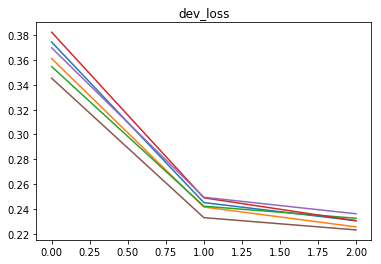

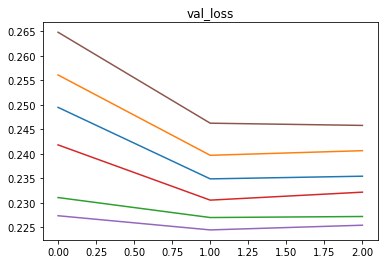

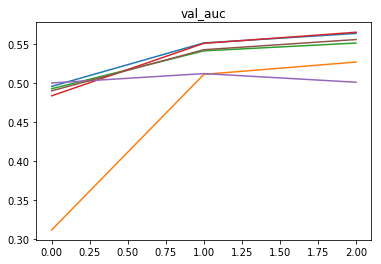

In [58]:
plt.figure()
plt.title('dev_loss')
for i_seed in range(n_seeds):
    for dev_loss in dev_loss_array[i_seed]:
        plt.plot(range(n_epochs), dev_loss)
plt.figure()
plt.title('val_loss')
for i_seed in range(n_seeds):
    for loss in val_loss_array[i_seed]:
        plt.plot(range(n_epochs), loss)
        
plt.figure()
plt.title('val_auc')
for i_seed in range(n_seeds):
    for loss in auc_array[i_seed]:
        plt.plot(range(n_epochs), loss)

In [59]:
def xentropy(y_true, y_pred):
    return loss_fn(torch.tensor(y_true), torch.tensor(y_pred)).item() / y_true.shape[0]

In [60]:
gc.collect()

8460

In [61]:
if debug:
    valid_df = train.iloc[:DEBUG_DATA_SIZE]
else:
    valid_df = train
from IPython.display import display

print('epoch_weighted')
weighted_auc_list = []
loss_list = []
for oof_seed in oof_train:
    oof_ew = np.average(oof_seed, weights=checkpoint_weights, axis=0)
    loss = xentropy(valid_df[TOXICITY_COLUMN].values, oof_ew)
    loss_list.append(loss)
    weighted_auc, overall_auc, bias_df = get_various_auc(valid_df, oof_ew)
    weighted_auc_list.append(weighted_auc)
print(f'weighted auc: mean: {np.mean(weighted_auc_list)}, std: {np.std(weighted_auc_list)}')
print(f'loss: mean: {np.mean(loss_list)}, std: {np.std(loss_list)}')

def last_n_ensemble(start_epoch):
    print()
    print(f'last {n_epochs - start_epoch}')
    weighted_auc_list = []
    for oof_seed in oof_train:
        oof_last = np.mean(oof_seed[start_epoch:], axis=0)
        loss = xentropy(valid_df[TOXICITY_COLUMN].values, oof_last)
        loss_list.append(loss)
        weighted_auc, overall_auc, bias_df = get_various_auc(valid_df, oof_last)
        weighted_auc_list.append(weighted_auc)
    print(f'weighted auc: mean: {np.mean(weighted_auc_list)}, std: {np.std(weighted_auc_list)}')
    print(f'loss: mean: {np.mean(loss_list)}, std: {np.std(loss_list)}')

for start_epoch in range(n_epochs):
    last_n_ensemble(start_epoch)
    gc.collect()

epoch_weighted
weighted auc: mean: 0.569235529848239, std: 0.0011428985889491705
loss: mean: 0.7317805690263401, std: 8.535897356887201e-06

last 3
weighted auc: mean: 0.5611823743140102, std: 0.0016325618862355062
loss: mean: 0.7322371767267093, std: 0.00045673477477276963

last 2
weighted auc: mean: 0.5716123478467763, std: 0.0013946140791532557
loss: mean: 0.7318963301973548, std: 0.0006094493392370998

last 1
weighted auc: mean: 0.5772950485497421, std: 0.001041098675323704
loss: mean: 0.7316664171012475, std: 0.0006611841060244852


In [62]:
oof_ew = np.mean(seed_oof_train_epoch_weighted_list, axis=0)
loss = xentropy(valid_df[TOXICITY_COLUMN].values, oof_ew)
print(f'loss: {loss}')
weighted_auc, overall_auc, bias_df = get_various_auc(valid_df, oof_ew)
print(weighted_auc, overall_auc)
display(bias_df)

loss: 0.73178056902634
0.5700390925056148 0.5321488616423756


,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
0,0.460878,0.612723,male,0.547114,216
6,0.413639,0.725689,black,0.557745,108
2,0.374850,0.722105,homosexual_gay_or_lesbian,0.598149,106
5,0.395531,0.731074,muslim,0.604167,34
1,0.457520,0.699095,female,0.623790,323
7,0.443971,0.725935,white,0.637108,131
3,0.420236,0.726156,christian,0.640000,130
4,0.536353,0.686037,jewish,0.668831,29
8,0.644491,0.737906,psychiatric_or_mental_illness,0.876603,61


In [63]:
def slice_ensemble(start_epoch, end_epoch):
    print()
    print(f'from {start_epoch} to {end_epoch}')
    weighted_auc_list = []
    for oof_seed in oof_train:
        oof_last = np.mean(oof_seed[start_epoch:end_epoch], axis=0)
        loss = xentropy(valid_df[TOXICITY_COLUMN].values, oof_last)
        loss_list.append(loss)
        weighted_auc, overall_auc, bias_df = get_various_auc(valid_df, oof_last)
        weighted_auc_list.append(weighted_auc)
    print(f'weighted auc: mean: {np.mean(weighted_auc_list)}, std: {np.std(weighted_auc_list)}')
    print(f'loss: mean: {np.mean(loss_list)}, std: {np.std(loss_list)}')

In [64]:
for end_epoch in range(10, n_epochs):
    slice_ensemble(2, end_epoch)
    gc.collect()